In [0]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import numpy as np
import re
import seaborn as sns
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


### Read data

In [0]:
df = pd.DataFrame(columns = ['label', 'content'])
folders = glob.glob("./datos/spam-filter/*")
for folder_aux in folders:
    folder_name = folder_aux + "/*"
    folder = glob.glob(folder_name)
    for file in folder:
        try:
            with open(file, encoding='utf-8') as f:
                content = f.read()
        except UnicodeDecodeError:
            with open(file, 'rb') as f:
                content = f.read()
        df = df.append({'label': 0 if 'ham' in folder_name else 1, 
                        'content': str(content).replace('\\n', '\n')}, ignore_index=True)

In [0]:
df.to_csv(r'datos/spam-filter/dataFrame.csv')
def remove_header(cols):
    array_first = cols[1].replace('\\n', '\n').split('\n')
    index_remove = 0
    pattern = r'^[A-Za-z-]*: [a-zA-Z 0-9@.[\]\(\)-]*'
    for index, element in enumerate(array_first):
        if re.search(pattern, element):
            index_remove = index
    return '\n'.join(array_first[index_remove + 1:]).strip()

def remove_tags_HTML(cols):
    content = cols[1]
    TAG_RE = re.compile(r'<[^>]+>')
    TAG_REX = re.compile(r"\s+")
    content = TAG_RE.sub('', content)
    content = TAG_REX.sub(' ', content)
    return content

def remove_spaces_tab(cols):
    content = cols[1]
    return content.replace("\n","").strip("\t")

def remove_web(cols):
    content = cols[1]
    TAG_RE = re.compile(r'https?:\/\/.*[\n]*')
    return TAG_RE.sub('', content)

def remove_numbers(cols):
    content = cols[1]
    TAG_RE = re.compile(r'[0-9]*')
    return TAG_RE.sub('', content)

In [0]:
df['content'] = df.apply(remove_header, axis=1)
df['content'] = df.apply(remove_tags_HTML, axis=1)
df['content'] = df.apply(remove_spaces_tab, axis=1)
df['content'] = df.apply(remove_numbers, axis=1)
df['content'] = df.apply(remove_web, axis=1)
X = df['content']
y = df['label']

### Procesamiento lenguaje

In [0]:
stemmer = SnowballStemmer("english")

def cleanText(message):   
   
    message = message.translate(str.maketrans('', '', string.punctuation))
    words = [stemmer.stem(word) for word in message.split() if word.lower() not in stopwords.words("english")]
    return " ".join(words)
    
X = list(map(cleanText, X))
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)
X = X.toarray()

## Regresión Logística

In [0]:
y=y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y , stratify = y, test_size = 0.3,random_state=101)
clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

In [0]:
print(accuracy_score(y_test, y_pred))

0.9455026455026455


In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1320
           1       0.96      0.86      0.90       570

   micro avg       0.95      0.95      0.95      1890
   macro avg       0.95      0.92      0.93      1890
weighted avg       0.95      0.95      0.94      1890



### Clasificador con RN

In [0]:
def grid_layers(capas):
    param = []
    for i in range(len(capas)):
        classifier = Sequential()
        classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 60982))
        for j in range(capas[i]-1):
            classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
        classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
        classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
        classifier.fit(X_train, y_train, batch_size = 50, epochs = 30)
        y_pred = classifier.predict(X_test)
        y_pred = (y_pred > 0.5)
        cm = confusion_matrix(y_test, y_pred)
        param.append([classifier.summary(),cm,classifier.evaluate(X_test, y_test)])
    return param
layers = [2,5,8]
resultado = grid_layers(layers)

Epoch 1/30
4409/4409 [==============================] - 4s 921us/step - loss: 0.6744 - acc: 0.7419
Epoch 2/30
4409/4409 [==============================] - 4s 801us/step - loss: 0.4822 - acc: 0.9428
Epoch 3/30
4409/4409 [==============================] - 4s 801us/step - loss: 0.2597 - acc: 0.9698
Epoch 4/30
4409/4409 [==============================] - 4s 800us/step - loss: 0.1559 - acc: 0.9785
Epoch 5/30
4409/4409 [==============================] - 4s 802us/step - loss: 0.1072 - acc: 0.9844
Epoch 6/30
4409/4409 [==============================] - 4s 804us/step - loss: 0.0804 - acc: 0.9866
Epoch 7/30
4409/4409 [==============================] - 4s 805us/step - loss: 0.0638 - acc: 0.9873
Epoch 8/30
4409/4409 [==============================] - 4s 800us/step - loss: 0.0527 - acc: 0.9880
Epoch 9/30
4409/4409 [==============================] - 4s 803us/step - loss: 0.0449 - acc: 0.9896
Epoch 10/30
4409/4409 [==============================] - 4s 797us/step - loss: 0.0391 - acc: 0.9900
Epoch 11/

4409/4409 [==============================] - 4s 810us/step - loss: 0.6339 - acc: 0.6986
Epoch 4/30
4409/4409 [==============================] - 4s 841us/step - loss: 0.6172 - acc: 0.6986
Epoch 5/30
4409/4409 [==============================] - 4s 847us/step - loss: 0.6126 - acc: 0.6986
Epoch 6/30
4409/4409 [==============================] - 4s 834us/step - loss: 0.6121 - acc: 0.6986
Epoch 7/30
4409/4409 [==============================] - 4s 842us/step - loss: 0.6122 - acc: 0.6986
Epoch 8/30
4409/4409 [==============================] - 4s 833us/step - loss: 0.6122 - acc: 0.6986
Epoch 9/30
4409/4409 [==============================] - 4s 837us/step - loss: 0.6121 - acc: 0.6986
Epoch 10/30
4409/4409 [==============================] - 4s 831us/step - loss: 0.6122 - acc: 0.6986
Epoch 11/30
4409/4409 [==============================] - 4s 839us/step - loss: 0.6122 - acc: 0.6986
Epoch 12/30
4409/4409 [==============================] - 4s 984us/step - loss: 0.6122 - acc: 0.6986
Epoch 13/30
4409/4

In [0]:
resultado
# EL indicado es el #2

[[None, array([[1290,   30],
         [  59,  511]], dtype=int64), [0.1833308524856216,
   0.9529100529100529]],
 [None, array([[1320,    0],
         [ 570,    0]], dtype=int64), [0.612204247082352, 0.6984126984126984]],
 [None, array([[1320,    0],
         [ 570,    0]], dtype=int64), [0.6122036979311989,
   0.6984126984126984]]]

In [0]:
precision = [i[2][1] for i in resultado]
plt.bar(["2 Capas","5 Capas","8 Capas"],precision)

In [0]:
def grid_neurons(neuronas):
    param = [] 
    for i in range(len(neuronas)):
        classifier = Sequential()
        classifier.add(Dense(units = neuronas[i], kernel_initializer = 'uniform', activation = 'relu', input_dim = 60982))
        classifier.add(Dense(units = neuronas[i], kernel_initializer = 'uniform', activation = 'relu'))
        classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
        classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
        classifier.fit(X_train, y_train, batch_size = 32, epochs = 30)
        y_pred = classifier.predict(X_test)
        y_pred = (y_pred > 0.5)
        cm = confusion_matrix(y_test, y_pred)
        param.append([classifier.summary(),cm,classifier.evaluate(X_test, y_test)])
    return param
neurons = [8,16,32,64]
resultado_neuronas = grid_neurons(neurons)

Epoch 1/30
4409/4409 [==============================] - 5s 1ms/step - loss: 0.5580 - acc: 0.6986
Epoch 2/30
4409/4409 [==============================] - 4s 950us/step - loss: 0.3134 - acc: 0.7954 0s - loss: 0.3172 - acc: 0.
Epoch 3/30
4409/4409 [==============================] - 4s 911us/step - loss: 0.1567 - acc: 0.9628
Epoch 4/30
4409/4409 [==============================] - 4s 909us/step - loss: 0.0827 - acc: 0.9782
Epoch 5/30
4409/4409 [==============================] - 4s 955us/step - loss: 0.0578 - acc: 0.9828
Epoch 6/30
4409/4409 [==============================] - 4s 957us/step - loss: 0.0441 - acc: 0.9866
Epoch 7/30
4409/4409 [==============================] - 4s 959us/step - loss: 0.0350 - acc: 0.9887 0s - loss: 0.0349 -
Epoch 8/30
4409/4409 [==============================] - 4s 960us/step - loss: 0.0293 - acc: 0.9912
Epoch 9/30
4409/4409 [==============================] - 4s 952us/step - loss: 0.0258 - acc: 0.9914 3s -
Epoch 10/30
4409/4409 [==============================] - 4

4409/4409 [==============================] - 8s 2ms/step - loss: 0.0303 - acc: 0.9930A: 1
Epoch 8/30
4409/4409 [==============================] - 8s 2ms/step - loss: 0.0286 - acc: 0.9934
Epoch 9/30
4409/4409 [==============================] - 8s 2ms/step - loss: 0.0275 - acc: 0.9936
Epoch 10/30
4409/4409 [==============================] - 8s 2ms/step - loss: 0.0268 - acc: 0.9939
Epoch 11/30
4409/4409 [==============================] - 8s 2ms/step - loss: 0.0260 - acc: 0.9936
Epoch 12/30
4409/4409 [==============================] - 8s 2ms/step - loss: 0.0256 - acc: 0.9939
Epoch 13/30
4409/4409 [==============================] - 8s 2ms/step - loss: 0.0256 - acc: 0.9934
Epoch 14/30
4409/4409 [==============================] - 8s 2ms/step - loss: 0.0253 - acc: 0.9936
Epoch 15/30
4409/4409 [==============================] - 8s 2ms/step - loss: 0.0251 - acc: 0.9936
Epoch 16/30
4409/4409 [==============================] - 9s 2ms/step - loss: 0.0250 - acc: 0.9939
Epoch 17/30
4409/4409 [=======

In [0]:
resultado_neuronas

[[None, array([[1295,   25],
         [  69,  501]], dtype=int64), [0.22836786856220065,
   0.9502645502645503]],
 [None, array([[1292,   28],
         [  62,  508]], dtype=int64), [0.25020826956652664,
   0.9523809523809523]],
 [None, array([[1293,   27],
         [  65,  505]], dtype=int64), [0.24309387730900198,
   0.9513227513227513]],
 [None, array([[1289,   31],
         [  67,  503]], dtype=int64), [0.2569881357933535,
   0.9481481481481482]]]

In [0]:
def regresor_base(optimizer,activation):
    modelo = Sequential()
    modelo.add(Dense(units = 8, kernel_initializer = 'uniform', activation = activation, input_dim = 60982))
    modelo.add(Dropout(p = 0.1))
    modelo.add(Dense(units = 8, kernel_initializer = 'uniform', activation = activation))
    modelo.add(Dropout(p = 0.1))
    modelo.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    modelo.compile(optimizer = optimizer, loss = 'binary_crossentropy' ,metrics = ['accuracy'])
    return  modelo

regresor = KerasClassifier(build_fn = regresor_base)
parameters = {'batch_size': [5,10,20,50],
              'epochs': [20,40,60,100],
              'optimizer': ['adam'],
              'activation':['sigmoid','relu']              
             }

## C.V
grid_search = GridSearchCV(estimator = regresor,
                           param_grid = parameters,
                           cv=2
                           )
grid_search = grid_search.fit(X_train, y_train)

**precisión del C.V de 91%**

In [0]:
resultado_neuronas

[[None, array([[1295,   25],
         [  69,  501]], dtype=int64), [0.22836786856220065,
   0.9502645502645503]],
 [None, array([[1292,   28],
         [  62,  508]], dtype=int64), [0.25020826956652664,
   0.9523809523809523]],
 [None, array([[1293,   27],
         [  65,  505]], dtype=int64), [0.24309387730900198,
   0.9513227513227513]],
 [None, array([[1289,   31],
         [  67,  503]], dtype=int64), [0.2569881357933535,
   0.9481481481481482]]]

In [0]:
neurons

[8, 16, 32, 64]

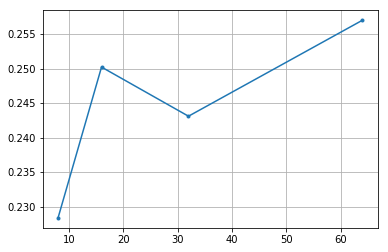

In [0]:
loss = [i[-1][0] for i in resultado_neuronas]
precission = [i[-1][1] for i in resultado_neuronas]
plt.plot(neurons, loss , '.-')
plt.grid()

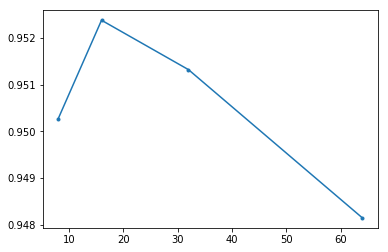

In [0]:
plt.plot(neurons, precission , '.-')

**Modelo final con hyper parametros ajustados**

**PRECISIÓN MÁS ALTA ES EN 16 Y MÁS BAJA EN 8**

In [0]:
classifier = Sequential()
classifier.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'sigmoid', input_dim = 60982))
classifier.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=5, verbose=1)
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)
classifier.fit(X_train, y_train, batch_size = 5, epochs = 100,callbacks=[es, rlr])
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

Epoch 1/100
4409/4409 [==============================] - 34s 8ms/step - loss: 0.4206 - acc: 0.7988
Epoch 2/100
4409/4409 [==============================] - 33s 7ms/step - loss: 0.1173 - acc: 0.9658
Epoch 3/100
4409/4409 [==============================] - 33s 8ms/step - loss: 0.0592 - acc: 0.9823
Epoch 4/100
4409/4409 [==============================] - 33s 7ms/step - loss: 0.0381 - acc: 0.9882
Epoch 5/100
4409/4409 [==============================] - 33s 8ms/step - loss: 0.0288 - acc: 0.9907
Epoch 6/100
4409/4409 [==============================] - 32s 7ms/step - loss: 0.0245 - acc: 0.9921
Epoch 7/100
4409/4409 [==============================] - 35s 8ms/step - loss: 0.0217 - acc: 0.9916
Epoch 8/100
4409/4409 [==============================] - 34s 8ms/step - loss: 0.0204 - acc: 0.9934
Epoch 9/100
4409/4409 [==============================] - 33s 8ms/step - loss: 0.0192 - acc: 0.9939
Epoch 10/100
4409/4409 [==============================] - 33s 7ms/step - loss: 0.0184 - acc: 0.9936
Epoch 11/

In [0]:
cm = confusion_matrix(y_test, y_pred)
classifier.evaluate(X_test, y_test)

1890/1890 [==============================] - 2s 1ms/step


[0.21218291513890364, 0.9476190476190476]

In [0]:
# RESULTADO DE LA REGRESION

    array([[1297,   23],
           [  80,  490]]